In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import qda

# Import the dataset
data = np.array((148.54,154.9,153.09,158.05,151.74,156.72,153.86,159.86,162.92,163.07,154.65,164.05,163.03,165,163.36,161.05,169.68,166.48,168.01,170.51))
df = pd.DataFrame(data, columns = ['Xbar'])
# Inspect the dataset
df.head()

,Xbar
0,148.54
1,154.90
2,153.09
3,158.05
4,151.74


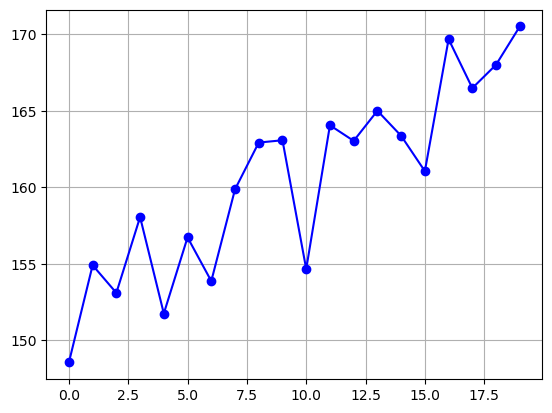

In [2]:
# Plot the data first
plt.plot(df, color='b', linestyle='-', marker='o')
plt.grid()
plt.show()

Runs test p-value = 0.001


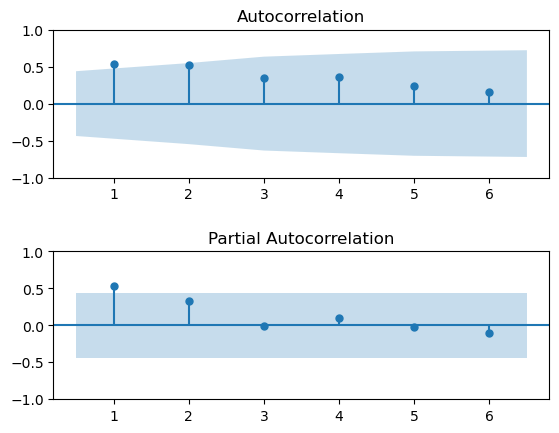

In [3]:
# Import the necessary libraries for the runs test
from statsmodels.sandbox.stats.runs import runstest_1samp

_, pval_runs = runstest_1samp(df['Xbar'], correction=False)
print('Runs test p-value = {:.3f}'.format(pval_runs))
# Plot the acf and pacf using the statsmodels library
import statsmodels.graphics.tsaplots as sgt

fig, ax = plt.subplots(2, 1)
sgt.plot_acf(df['Xbar'], lags = int(len(data)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(df['Xbar'], lags = int(len(data)/3), zero=False, ax=ax[1], method = 'ywm')
plt.show()


In [15]:
import statsmodels.api as sm

df['time']=np.arange(1,21,1)

x = df['time']
x = sm.add_constant(x) 
y = df['Xbar']
model = sm.OLS(y, x).fit()

qda.summary(model)


REGRESSION EQUATION
-------------------
Xbar =  + 150.613 const + 0.935 time

COEFFICIENTS
------------
 Term     Coef  SE Coef  T-Value    P-Value
const 150.6129   1.3878 108.5275 8.3241e-27
 time   0.9348   0.1159   8.0692 2.1673e-07

MODEL SUMMARY
-------------
     S   R-sq  R-sq(adj)
2.9875 0.7834     0.7714

ANALYSIS OF VARIANCE
---------------------
    Source   DF      Adj SS      Adj MS    F-Value    P-Value
Regression  1.0    581.1352    581.1352    65.1123 2.1673e-07
     const  1.0 105122.1066 105122.1066 11778.2254 8.3241e-27
      time  1.0    581.1352    581.1352    65.1123 2.1673e-07
     Error 18.0    160.6522      8.9251        NaN        NaN
     Total 19.0    741.7875         NaN        NaN        NaN


Shapiro-Wilk test p-value = 0.340


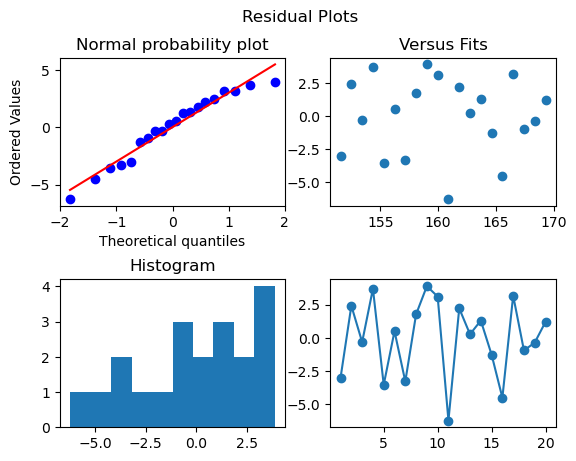

In [16]:
#Check on residuals
residuals = model.resid
fits = model.fittedvalues
# Perform the Shapiro-Wilk test
_, pval_SW = stats.shapiro(residuals)
print('Shapiro-Wilk test p-value = %.3f' % pval_SW)

# Plot the residuals
fig, axs = plt.subplots(2, 2)
fig.suptitle('Residual Plots')
stats.probplot(residuals, dist="norm", plot=axs[0,0])
axs[0,0].set_title('Normal probability plot')
axs[0,1].scatter(fits, residuals)
axs[0,1].set_title('Versus Fits')
fig.subplots_adjust(hspace=0.5)
axs[1,0].hist(residuals)
axs[1,0].set_title('Histogram')
axs[1,1].plot(np.arange(1, len(residuals)+1), residuals, 'o-')
plt.show()

Runs test p-value on the residuals = 0.150


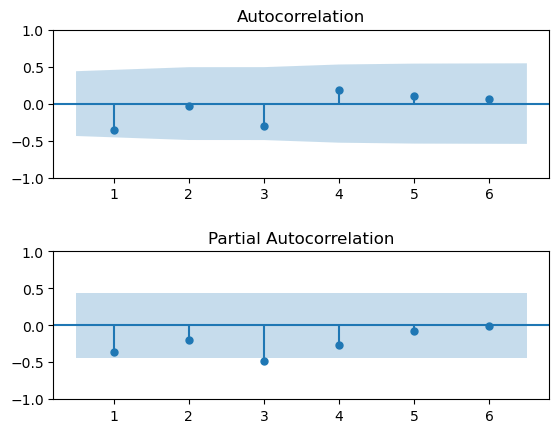

In [17]:
#RANDOMNESS OF FESIDUALS
_, pval_runs_res = runstest_1samp(residuals, correction=False)
print('Runs test p-value on the residuals = {:.3f}'.format(pval_runs_res))
fig, ax = plt.subplots(2, 1)
sgt.plot_acf(residuals, lags = int(len(data)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(residuals, lags = int(len(data)/3), zero=False, ax=ax[1], 
            method = 'ywm')
plt.show()

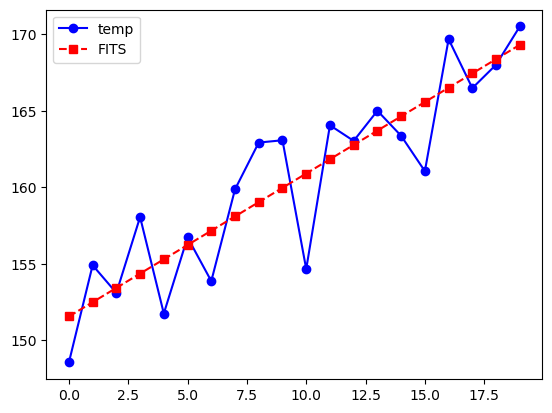

In [18]:
plt.plot(df['Xbar'], color='b', linestyle='-', marker='o', label='temp')
plt.plot(model.fittedvalues, color='r', linestyle='--', marker='s', label='FITS')
plt.legend()
plt.show()

In [19]:
df_res = pd.DataFrame({'I': model.resid})
df_res['MR'] = df_res['I'].diff().abs()

df_res.describe()

,I,MR
count,2.0000e+01,19.0000
mean,9.2371e-14,3.9934
std,2.9078e+00,2.6304
min,-6.2459e+00,0.5952
25%,-1.7083e+00,2.0400
50%,3.8132e-01,3.7948
75%,2.2688e+00,5.2452
max,3.8937e+00,9.3548


In [23]:
# Let's reuse the old dataframe df
# Replace the I_CL column with the fitted values
d2 = qda.constants.getd2(2)
alpha=1/250
K_alpha=stats.norm.ppf(1-alpha/2)
df['I_CL'] = model.fittedvalues

# Replace the I_UCL and I_LCL columns with the upper and 
# lower control limits computed from the formula
df['I_UCL'] = df['I_CL'] + K_alpha * df_res['MR'].mean() / d2
df['I_LCL'] = df['I_CL'] - K_alpha * df_res['MR'].mean() / d2

# Also update the TEST1 column
df['I_TEST1'] = np.where((df['Xbar'] > df['I_UCL']) | (df['Xbar'] < df['I_LCL']), df['Xbar'], np.nan)


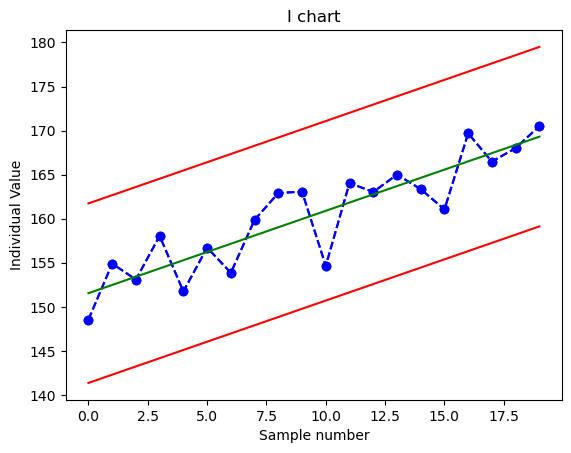

In [24]:
# Plot the I chart
plt.title('I chart')
plt.plot(df['Xbar'], color='b', linestyle='--', marker='o')
plt.plot(df['Xbar'], color='b', linestyle='--', marker='o')
plt.plot(df['I_UCL'], color='r')
plt.plot(df['I_CL'], color='g')
plt.plot(df['I_LCL'], color='r')
plt.ylabel('Individual Value')
plt.xlabel('Sample number')
# highlight the points that violate the alarm rules
plt.plot(df['I_TEST1'], linestyle='none', marker='s', 
        color='r', markersize=10)

plt.show()

>## Point 2

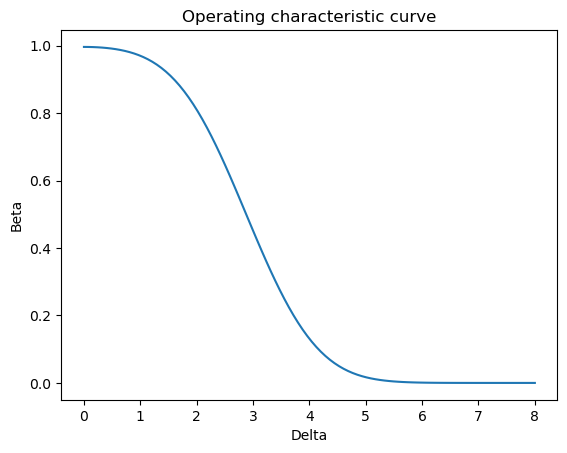

In [28]:
delta_0=np.linspace(0,8,100)
beta=stats.norm.cdf(K_alpha-delta_0)-stats.norm.cdf(-K_alpha-delta_0)

# Plot the beta values
plt.plot(delta_0, beta)
plt.xlabel('Delta')
plt.ylabel('Beta')
plt.title('Operating characteristic curve')
plt.show()

>## Point 3

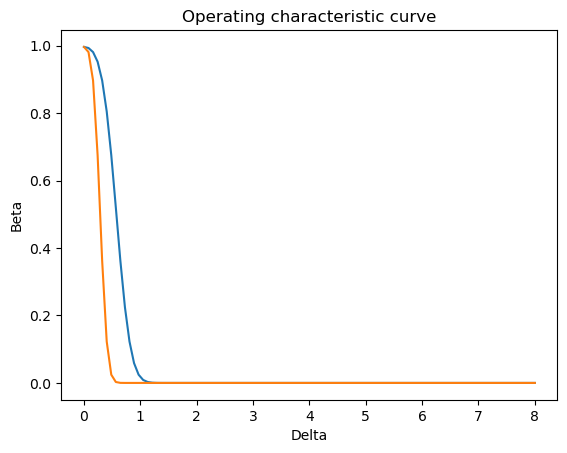

In [34]:
delta_0=np.linspace(0,8,100)
t=[5,10]
beta1=stats.norm.cdf(K_alpha-delta_0*t[0])-stats.norm.cdf(-K_alpha-delta_0*t[0])
beta2=stats.norm.cdf(K_alpha-delta_0*t[1])-stats.norm.cdf(-K_alpha-delta_0*t[1])
# Plot the beta values
plt.plot(delta_0, beta1)
plt.plot(delta_0,beta2)
plt.xlabel('Delta')
plt.ylabel('Beta')
plt.title('Operating characteristic curve')
plt.show()